<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [3]</a>'.</span>

#  TP : Data Centers, Green IT et Data Science
### Master 2 – Data / IA

---

## Objectifs du TP
- Manipuler un **dataset réel** lié aux infrastructures numériques.
- Explorer les **enjeux énergétiques et environnementaux** des data centers.
- Développer des compétences en **nettoyage, analyse et visualisation de données**.
- Relier l’analyse statistique aux **cadres réglementaires (UE, USA, Singapour, Australie)**.
- Appliquer des techniques de **Data Science (corrélations, modèles de régression)**.
- Mettre en œuvre un pipeline simple de **CI/CD** pour automatiser l’analyse.


##  Données
Fichier fourni : `Book1.csv` (extrait d’une base mondiale de data centers).

Variables principales :
- `Country` : pays
- `Continent` : continent
- `Number of data centres` : nombre total recensé
- `Gross Power (MW)` : puissance électrique installée
- `Renewable Energy Usage (%)` : part estimée d’énergie renouvelable
- Autres colonnes liées aux surfaces, capacités, données disponibles…


## Partie 1 — Préparation & Nettoyage des données
**Travail attendu :**
1. Charger le dataset avec `pandas`.
2. Vérifier le nombre de lignes/colonnes et explorer les 5 premières lignes.
3. Identifier et traiter les valeurs manquantes (par suppression ou imputation).
4. Supprimer les colonnes inutiles pour l’analyse.
5. Construire un **mini dictionnaire de données** avec 3 colonnes clés.

 **Question :** pourquoi un dictionnaire de données est-il indispensable dans un projet de gouvernance des données ?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display

# 1) Charger le dataset
print("="*60)
print("PARTIE 1 — PRÉPARATION & NETTOYAGE DES DONNÉES")
print("="*60)

# Chargement automatique du fichier CSV
import os
fname = "Book1.csv" if os.path.exists("Book1.csv") else "Book1 (1).csv"
df = pd.read_csv(fname)

print(f"\n1) Dataset chargé : {fname}")
print(f"   Forme du dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes")

# 2) Explorer les 5 premières lignes
print("\n2) Aperçu des 5 premières lignes :")
display(df.head())

print("\n   Colonnes disponibles :")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

# 3) Identifier et traiter les valeurs manquantes
print("\n3) Analyse des valeurs manquantes :")
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Colonne': missing_counts.index,
    'Valeurs manquantes': missing_counts.values,
    'Pourcentage (%)': missing_percent.values
}).sort_values('Valeurs manquantes', ascending=False)

print("\n   Résumé des valeurs manquantes :")
display(missing_df[missing_df['Valeurs manquantes'] > 0])

# 4) Supprimer les colonnes inutiles et garder les colonnes clés
print("\n4) Sélection des colonnes clés pour l'analyse :")

# Colonnes essentielles pour l'analyse
colonnes_cles = [
    'country',
    'total_data_centers', 
    'power_capacity_MW_total',
    'average_renewable_energy_usage_percent'
]

# Vérifier que les colonnes existent
missing_cols = [col for col in colonnes_cles if col not in df.columns]
if missing_cols:
    print(f"   ⚠️  ATTENTION : Colonnes manquantes : {missing_cols}")
    print(f"   Colonnes disponibles : {list(df.columns)}")
else:
    print(f"   ✅ Toutes les colonnes clés sont présentes")

# Créer le dataset nettoyé
df_clean = df[colonnes_cles].copy()
print(f"   Dataset réduit : {df_clean.shape[0]} lignes × {df_clean.shape[1]} colonnes")

# 5) Nettoyage robuste des données

# 5a) total_data_centers -> entier
print("\n5) Nettoyage des données :")
print("   a) Nettoyage de 'total_data_centers'...")
df_clean['total_data_centers'] = pd.to_numeric(df_clean['total_data_centers'], errors='coerce').fillna(0).astype(int)

# 5b) power_capacity_MW_total -> float (nettoyage robuste)
print("   b) Nettoyage de 'power_capacity_MW_total'...")
def clean_power(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().lower()
    if s in {'unknown', 'na', 'n/a', '-', '--', ''}:
        return np.nan
    # Enlever les caractères non numériques sauf le point
    s = re.sub(r'[~+,\s]', '', s)  # retire ~, +, virgules, espaces
    s = re.sub(r'[^\d.]', '', s)   # garde seulement chiffres et points
    # Gérer les multiples points (garder seulement le dernier)
    s = re.sub(r'\.(?=.*\.)', '', s)
    if s in {'', '.'}:
        return np.nan
    try:
        return float(s)
    except:
        return np.nan

df_clean['power_capacity_num'] = df_clean['power_capacity_MW_total'].apply(clean_power)

# 5c) average_renewable_energy_usage_percent -> float (0-100)
print("   c) Nettoyage de 'average_renewable_energy_usage_percent'...")
def clean_renewable_percent(val):
    if pd.isna(val):
        return np.nan
    s = str(val).replace('+', '').strip()
    if '%' in s:
        # Cas "40%" ou "~27%"
        s = re.sub(r'[^0-9.]', '', s)
        if not s:
            return np.nan
        return float(s)
    # Cas numérique
    try:
        x = float(s)
        # Si ≤ 1, c'est probablement une fraction (0.25 = 25%)
        return x * 100 if x <= 1 else x
    except:
        return np.nan

df_clean['renewable_percent'] = df_clean['average_renewable_energy_usage_percent'].apply(clean_renewable_percent)
# Limiter entre 0 et 100
df_clean['renewable_percent'] = df_clean['renewable_percent'].clip(0, 100)

# Résumé du nettoyage
print("\n   Résumé après nettoyage :")
print(f"   - Pays : {df_clean['country'].nunique()} pays uniques")
print(f"   - Data centers : {df_clean['total_data_centers'].sum():,} au total")
print(f"   - Puissance : {df_clean['power_capacity_num'].count()} valeurs valides")
print(f"   - % Renouvelable : {df_clean['renewable_percent'].count()} valeurs valides")

# Aperçu final
print("\n   Aperçu des données nettoyées :")
display(df_clean[['country', 'total_data_centers', 'power_capacity_num', 'renewable_percent']].head())



PARTIE 1 — PRÉPARATION & NETTOYAGE DES DONNÉES

1) Dataset chargé : Book1 (1).csv
   Forme du dataset : 191 lignes × 21 colonnes

2) Aperçu des 5 premières lignes :


,country,total_data_centers,hyperscale_data_centers,colocation_data_centers,floor_space_sqft_total,power_capacity_MW_total,average_renewable_energy_usage_percent,tier_distribution,key_operators,cloud_provider,...,avg_latency_to_global_hubs_ms,number_of_fiber_connections,growth_rate_of_data_centers_percent_per_year,cooling_technologies_common,regulatory_challenges_or_limits,disaster_recovery_sites_common,green_dc_initiatives_description,source_of_data,Unnamed: 19,Unnamed: 20
0,United States,5426,300+,"~2,000+","~3,552,000,000","~12,000+",~27%,"I:5%, II:15%, III:60%, IV:20%","Equinix, Digital Realty, CoreSite, AWS","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",...,40,60+,12%,"Air, Liquid, Immersion","Power grid strain in VA, moratoriums in some s...","Yes, especially for finance/health","Solar, wind PPA, immersion cooling, LEED","Statista, Brightlio, IEA, CBRE",NaN,NaN
1,Germany,529,50,~200,"~350,000,000","~2,000+",40%+,"II:10%, III:70%, IV:20%","Equinix, Digital Realty, e-shelter","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",...,50,30+,8%,"Air, Indirect Evap.","Power caps in Frankfurt, strict emissions","Yes, especially for finance","Wind, solar, carbon-neutral push","Statista, CBRE, IEA",NaN,NaN
2,United Kingdom,523,30,~150,"~200,000,000","~1,000+",0.45,"II:15%, III:70%, IV:15%","Equinix, Telehouse, Virtus","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",...,40,25+,7%,"Air, Free Cooling",Power grid constraints in London,"Yes, especially for finance","Wind, solar, carbon-neutral targets","Statista, CBRE, IEA",NaN,NaN
3,China,449,100,"~1,000+","~500,000,000","~8,000+",0.25,"II:20%, III:60%, IV:20%","China Unicom, Tencent, Alibaba, GDS","AWS:Yes, GCP:No, Azure:Yes, Oracle:Yes",...,75,40+,15%,"Air, Liquid",Power rationing in some provinces,"Yes, for government/finance","Hydro, wind, solar, green finance","Statista, CBRE, IEA",NaN,NaN
4,France,322,20,~110,"~120,000,000",~700,40%+,"II:20%, III:70%, IV:10%","Equinix, Interxion, Data4","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",...,50,20+,6%,"Air, Liquid",Power grid constraints in Paris,"Yes, for finance/health","Wind, solar, PUE targets","Statista, CBRE, IEA",NaN,NaN



   Colonnes disponibles :
    1. country
    2. total_data_centers
    3. hyperscale_data_centers
    4. colocation_data_centers
    5. floor_space_sqft_total
    6. power_capacity_MW_total
    7. average_renewable_energy_usage_percent
    8. tier_distribution
    9. key_operators
   10. cloud_provider
   11. internet_penetration_percent
   12. avg_latency_to_global_hubs_ms
   13. number_of_fiber_connections
   14. growth_rate_of_data_centers_percent_per_year
   15. cooling_technologies_common
   16. regulatory_challenges_or_limits
   17. disaster_recovery_sites_common
   18. green_dc_initiatives_description
   19. source_of_data
   20. Unnamed: 19
   21. Unnamed: 20

3) Analyse des valeurs manquantes :

   Résumé des valeurs manquantes :


,Colonne,Valeurs manquantes,Pourcentage (%)
20,Unnamed: 20,190,99.476440
19,Unnamed: 19,186,97.382199
9,cloud_provider,42,21.989529
17,green_dc_initiatives_description,26,13.612565
8,key_operators,21,10.994764
16,disaster_recovery_sites_common,13,6.806283
7,tier_distribution,12,6.282723
18,source_of_data,4,2.094241
13,growth_rate_of_data_centers_percent_per_year,2,1.047120
14,cooling_technologies_common,1,0.523560



4) Sélection des colonnes clés pour l'analyse :
   ✅ Toutes les colonnes clés sont présentes
   Dataset réduit : 191 lignes × 4 colonnes

5) Nettoyage des données :
   a) Nettoyage de 'total_data_centers'...
   b) Nettoyage de 'power_capacity_MW_total'...
   c) Nettoyage de 'average_renewable_energy_usage_percent'...

   Résumé après nettoyage :
   - Pays : 191 pays uniques
   - Data centers : 11,591 au total
   - Puissance : 165 valeurs valides
   - % Renouvelable : 147 valeurs valides

   Aperçu des données nettoyées :


,country,total_data_centers,power_capacity_num,renewable_percent
0,United States,5426,12000.0,27.0
1,Germany,529,2000.0,40.0
2,United Kingdom,523,1000.0,45.0
3,China,449,8000.0,25.0
4,France,322,700.0,40.0


## Partie 2 — Exploration et Visualisation
**Travail attendu :**
1. Identifier les **10 pays** avec le plus grand nombre de data centers.
   - Afficher sous forme de tableau.
   - Tracer un graphique en barres.
2. Représenter la distribution de la **puissance installée (MW)**.
3. Tracer un **scatter plot** entre `Gross Power (MW)` et `% renouvelable`.

 **Question :** commentez la relation observée. Est-ce que la puissance d’un data center permet de prédire sa durabilité ?


1) TOP 10 PAYS PAR NOMBRE DE DATA CENTERS
--------------------------------------------------
Tableau des 10 pays avec le plus de data centers :


,country,total_data_centers
182,United States,5426
64,Germany,529
181,United Kingdom,523
35,China,449
30,Canada,336
60,France,322
8,Australia,314
122,Netherlands,298
141,Russia,251
84,Japan,222


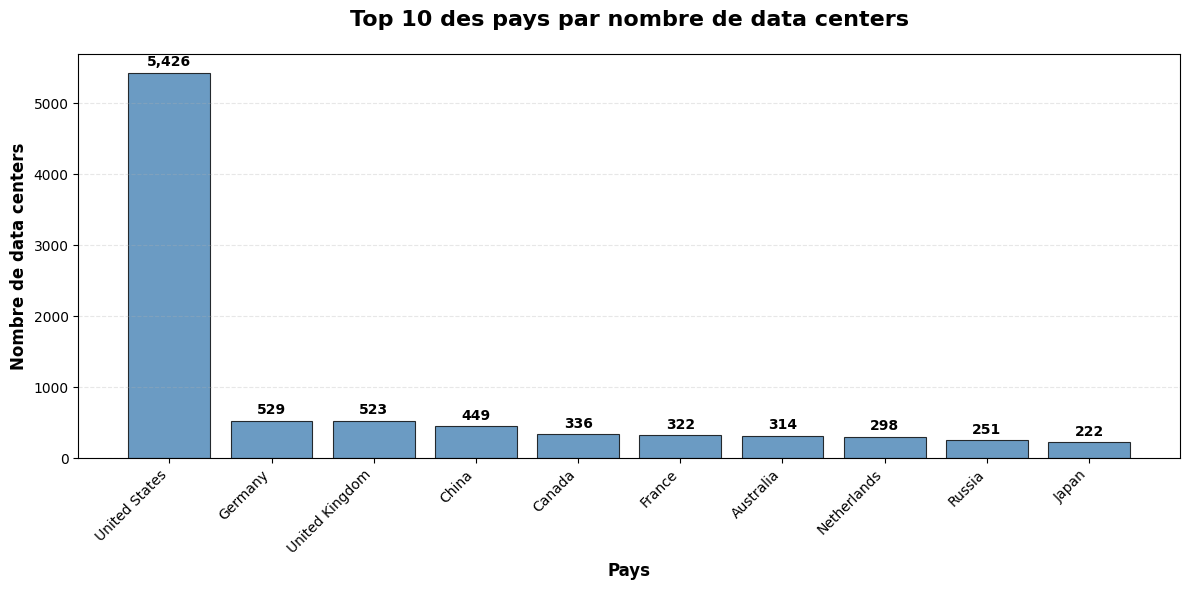


2) DISTRIBUTION DE LA PUISSANCE INSTALLÉE (MW)
--------------------------------------------------
Nombre de valeurs valides : 165
Puissance minimale : 0.0 MW
Puissance maximale : 12000.0 MW
Puissance moyenne : 275.3 MW
Puissance médiane : 15.0 MW


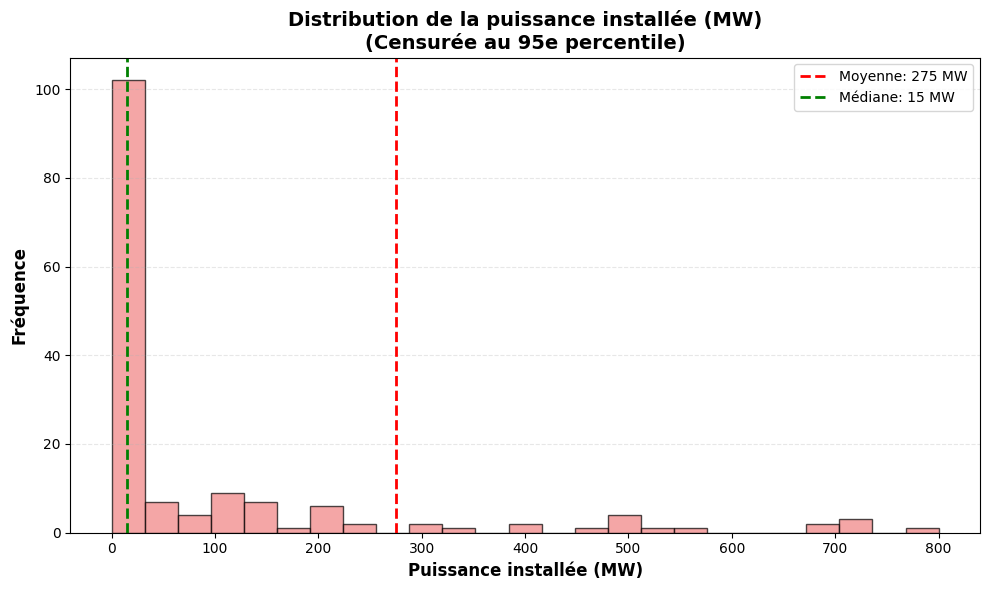


3) RELATION PUISSANCE vs % ÉNERGIE RENOUVELABLE
--------------------------------------------------
Nombre de points pour le scatter plot : 146


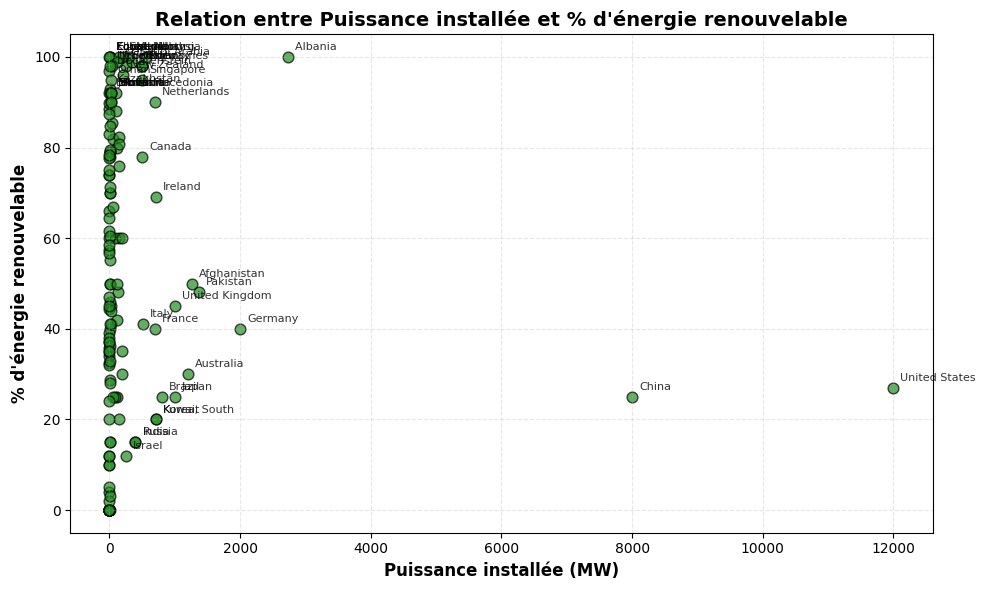

Coefficient de corrélation : -0.062
→ Corrélation faible

RÉSUMÉ DE L'ANALYSE


In [2]:
# 1) Top 10 pays par nombre de data centers
print("\n1) TOP 10 PAYS PAR NOMBRE DE DATA CENTERS")
print("-" * 50)

top10_pays = (df_clean.groupby('country', as_index=False)['total_data_centers']
              .sum()
              .sort_values('total_data_centers', ascending=False)
              .head(10))

print("Tableau des 10 pays avec le plus de data centers :")
display(top10_pays)

# Graphique en barres
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(top10_pays)), top10_pays['total_data_centers'], 
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=0.8)

# Ajouter les valeurs sur les barres
for i, (bar, value) in enumerate(zip(bars, top10_pays['total_data_centers'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

plt.title('Top 10 des pays par nombre de data centers', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Pays', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de data centers', fontsize=12, fontweight='bold')
plt.xticks(range(len(top10_pays)), top10_pays['country'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2) Distribution de la puissance installée (MW)
print("\n2) DISTRIBUTION DE LA PUISSANCE INSTALLÉE (MW)")
print("-" * 50)

puissances_valides = df_clean['power_capacity_num'].dropna()
print(f"Nombre de valeurs valides : {len(puissances_valides)}")
print(f"Puissance minimale : {puissances_valides.min():.1f} MW")
print(f"Puissance maximale : {puissances_valides.max():.1f} MW")
print(f"Puissance moyenne : {puissances_valides.mean():.1f} MW")
print(f"Puissance médiane : {puissances_valides.median():.1f} MW")

if len(puissances_valides) > 0:
    # Censurer au 95e percentile pour la visualisation
    cap_95 = puissances_valides.quantile(0.95)
    puissances_filtered = puissances_valides[puissances_valides <= cap_95]
    
    plt.figure(figsize=(10, 6))
    plt.hist(puissances_filtered, bins=25, color='lightcoral', alpha=0.7, edgecolor='black')
    plt.axvline(puissances_valides.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Moyenne: {puissances_valides.mean():.0f} MW')
    plt.axvline(puissances_valides.median(), color='green', linestyle='--', linewidth=2,
                label=f'Médiane: {puissances_valides.median():.0f} MW')
    
    plt.title('Distribution de la puissance installée (MW)\n(Censurée au 95e percentile)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Puissance installée (MW)', fontsize=12, fontweight='bold')
    plt.ylabel('Fréquence', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Aucune donnée valide pour créer l'histogramme")

# 3) Scatter plot : Puissance vs % Renouvelable
print("\n3) RELATION PUISSANCE vs % ÉNERGIE RENOUVELABLE")
print("-" * 50)

# Données pour le scatter plot
scatter_data = df_clean[['country', 'power_capacity_num', 'renewable_percent']].dropna()
print(f"Nombre de points pour le scatter plot : {len(scatter_data)}")

if len(scatter_data) > 0:
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(scatter_data['power_capacity_num'], 
                         scatter_data['renewable_percent'],
                         alpha=0.7, s=60, color='forestgreen', edgecolors='black')
    
    # Ajouter les noms des pays pour les points les plus intéressants
    # (puissance élevée ou % renouvelable élevé)
    for _, row in scatter_data.iterrows():
        if (row['power_capacity_num'] > scatter_data['power_capacity_num'].quantile(0.8) or 
            row['renewable_percent'] > scatter_data['renewable_percent'].quantile(0.8)):
            plt.annotate(row['country'], 
                        (row['power_capacity_num'], row['renewable_percent']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
    
    plt.title('Relation entre Puissance installée et % d\'énergie renouvelable', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Puissance installée (MW)', fontsize=12, fontweight='bold')
    plt.ylabel('% d\'énergie renouvelable', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Statistiques de corrélation
    correlation = scatter_data['power_capacity_num'].corr(scatter_data['renewable_percent'])
    print(f"Coefficient de corrélation : {correlation:.3f}")
    if abs(correlation) > 0.7:
        print("→ Corrélation forte")
    elif abs(correlation) > 0.3:
        print("→ Corrélation modérée")
    else:
        print("→ Corrélation faible")
else:
    print("⚠️ Données insuffisantes pour le scatter plot")

print("\n" + "="*60)
print("RÉSUMÉ DE L'ANALYSE")


## Partie 3 — Comparaison intercontinentale
**Travail attendu :**
1. Agréger par **continent** le `% d’énergie renouvelable`.
2. Comparer les continents dans un **bar chart**.
3. Focus sur l’Europe vs Amérique du Nord :
   - Calculer la moyenne et l’écart-type du `% renouvelable`.
   - Discuter les différences en lien avec les lois (EED en Europe vs ENERGY STAR aux USA).

 **Question :** que montrent ces écarts sur l’efficacité des lois européennes par rapport aux approches volontaires américaines ?

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats  # Pour les tests statistiques (optionnel)

print("="*60)
print("PARTIE 3 — COMPARAISON INTERCONTINENTALE")
print("="*60)

# 1) Mapping des pays vers les continents
print("\n1) ATTRIBUTION DES CONTINENTS AUX PAYS")
print("-" * 50)

def map_continent(country):
  {
    # Europe
    'Albania': 'Europe', 'Andorra': 'Europe', 'Austria': 'Europe', 'Belarus': 'Europe',
    'Belgium': 'Europe', 'Bosnia and Herzegovina': 'Europe', 'Bulgaria': 'Europe',
    'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czechia': 'Europe', 'Denmark': 'Europe',
    'Estonia': 'Europe', 'Finland': 'Europe', 'France': 'Europe', 'Germany': 'Europe',
    'Greece': 'Europe', 'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe',
    'Italy': 'Europe', 'Latvia': 'Europe', 'Liechtenstein': 'Europe', 'Lithuania': 'Europe',
    'Luxembourg': 'Europe', 'Malta': 'Europe', 'Moldova': 'Europe', 'Monaco': 'Europe',
    'Montenegro': 'Europe', 'Netherlands': 'Europe', 'North Macedonia': 'Europe',
    'Norway': 'Europe', 'Poland': 'Europe', 'Portugal': 'Europe', 'Romania': 'Europe',
    'Russia': 'Europe', 'San Marino': 'Europe', 'Serbia': 'Europe', 'Slovakia': 'Europe',
    'Slovenia': 'Europe', 'Spain': 'Europe', 'Sweden': 'Europe', 'Switzerland': 'Europe',
    'Türkiye': 'Europe', 'Ukraine': 'Europe', 'United Kingdom': 'Europe',
    
    # Amérique du Nord
    'Canada': 'North America', 'Mexico': 'North America', 'United States': 'North America',
    
    # Amérique du Sud
    'Argentina': 'South America', 'Bolivia': 'South America', 'Brazil': 'South America',
    'Chile': 'South America', 'Colombia': 'South America', 'Ecuador': 'South America',
    'Guyana': 'South America', 'Paraguay': 'South America', 'Peru': 'South America',
    'Suriname': 'South America', 'Uruguay': 'South America', 'Venezuela': 'South America',
    
    # Asie
    'Afghanistan': 'Asia', 'Armenia': 'Asia', 'Azerbaijan': 'Asia', 'Bangladesh': 'Asia',
    'Bhutan': 'Asia', 'Brunei': 'Asia', 'Cambodia': 'Asia', 'China': 'Asia',
    'Georgia': 'Asia', 'India': 'Asia', 'Indonesia': 'Asia', 'Iran': 'Asia',
    'Iraq': 'Asia', 'Israel': 'Asia', 'Japan': 'Asia', 'Jordan': 'Asia',
    'Kazakhstan': 'Asia', 'Kuwait': 'Asia', 'Kyrgyzstan': 'Asia', 'Laos': 'Asia',
    'Lebanon': 'Asia', 'Malaysia': 'Asia', 'Maldives': 'Asia', 'Mongolia': 'Asia',
    'Myanmar': 'Asia', 'Nepal': 'Asia', 'Korea, North': 'Asia', 'Korea, South': 'Asia',
    'Oman': 'Asia', 'Pakistan': 'Asia', 'Palau': 'Asia', 'Philippines': 'Asia',
    'Qatar': 'Asia', 'Saudi Arabia': 'Asia', 'Singapore': 'Asia', 'Sri Lanka': 'Asia',
    'Syria': 'Asia', 'Tajikistan': 'Asia', 'Thailand': 'Asia', 'Timor-Leste': 'Asia',
    'Turkmenistan': 'Asia', 'United Arab Emirates': 'Asia', 'Uzbekistan': 'Asia',
    'Vietnam': 'Asia', 'Yemen': 'Asia',
    
    # Océanie
    'Australia': 'Oceania', 'Fiji': 'Oceania', 'Kiribati': 'Oceania',
    'Marshall Islands': 'Oceania', 'Micronesia': 'Oceania', 'New Zealand': 'Oceania',
    'Papua New Guinea': 'Oceania', 'Samoa': 'Oceania', 'Solomon Islands': 'Oceania',
    'Tonga': 'Oceania', 'Tuvalu': 'Oceania', 'Vanuatu': 'Oceania',
    
    # Afrique
    'Algeria': 'Africa', 'Angola': 'Africa', 'Benin': 'Africa', 'Botswana': 'Africa',
    'Burkina Faso': 'Africa', 'Burundi': 'Africa', 'Cameroon': 'Africa',
    'Cape Verde': 'Africa', 'Central African Republic': 'Africa', 'Chad': 'Africa',
    'Comoros': 'Africa', 'Congo, Democratic Republic of the': 'Africa',
    'Congo, Republic of the': 'Africa', 'Côte d\'Ivoire': 'Africa', 'Djibouti': 'Africa',
    'Egypt': 'Africa', 'Equatorial Guinea': 'Africa', 'Eritrea': 'Africa',
    'Eswatini': 'Africa', 'Ethiopia': 'Africa', 'Gabon': 'Africa', 'Gambia': 'Africa',
    'Ghana': 'Africa', 'Guinea': 'Africa', 'Guinea-Bissau': 'Africa', 'Kenya': 'Africa',
    'Lesotho': 'Africa', 'Liberia': 'Africa', 'Libya': 'Africa', 'Madagascar': 'Africa',
    'Malawi': 'Africa', 'Mali': 'Africa', 'Mauritania': 'Africa', 'Mauritius': 'Africa',
    'Morocco': 'Africa', 'Mozambique': 'Africa', 'Namibia': 'Africa', 'Niger': 'Africa',
    'Nigeria': 'Africa', 'Rwanda': 'Africa', 'Sao Tome and Principe': 'Africa',
    'Senegal': 'Africa', 'Seychelles': 'Africa', 'Sierra Leone': 'Africa',
    'Somalia': 'Africa', 'South Africa': 'Africa', 'South Sudan': 'Africa',
    'Sudan': 'Africa', 'Tanzania': 'Africa', 'Togo': 'Africa', 'Tunisia': 'Africa',
    'Uganda': 'Africa', 'Zambia': 'Africa', 'Zimbabwe': 'Africa',
    
    # Amérique centrale et Caraïbes
    'Antigua and Barbuda': 'Central America', 'Bahamas': 'Central America',
    'Barbados': 'Central America', 'Belize': 'Central America', 'Costa Rica': 'Central America',
    'Cuba': 'Central America', 'Dominica': 'Central America', 'Dominican Republic': 'Central America',
    'El Salvador': 'Central America', 'Grenada': 'Central America', 'Guatemala': 'Central America',
    'Haiti': 'Central America', 'Honduras': 'Central America', 'Jamaica': 'Central America',
    'Nicaragua': 'Central America', 'Panama': 'Central America',
    'Saint Kitts and Nevis': 'Central America', 'Saint Lucia': 'Central America',
    'Saint Vincent and the Grenadines': 'Central America', 'Trinidad and Tobago': 'Central America'
}
    
   
# Calcul des statistiques par continent
continent_stats = continent_data.groupby("continent")["renewable_percent"].agg([
    'count', 'mean', 'std', 'median', 'min', 'max'
]).round(1)

continent_stats.columns = ['Nb_pays', 'Moyenne_%', 'Ecart_type_%', 'Médiane_%', 'Min_%', 'Max_%']

print("\nStatistiques détaillées par continent :")
display(continent_stats)

# Préparer les données pour le graphique (tri par moyenne décroissante)
chart_data = continent_data.groupby("continent", as_index=False)["renewable_percent"].mean()
chart_data = chart_data.sort_values("renewable_percent", ascending=False)

print(f"\nClassement des continents (% renouvelable moyen) :")
for i, row in chart_data.iterrows():
    nb_pays = continent_stats.loc[row['continent'], 'Nb_pays']
    print(f"   {i+1}. {row['continent']:15s} : {row['renewable_percent']:5.1f}% (sur {nb_pays} pays)")

# 3) Bar chart comparatif des continents
print("\n\n3) GRAPHIQUE COMPARATIF PAR CONTINENT")
print("-" * 50)

plt.figure(figsize=(12, 7))

# Créer le graphique avec couleurs distinctes
colors = ['#2E8B57', '#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
bars = plt.bar(chart_data["continent"], chart_data["renewable_percent"], 
               color=colors[:len(chart_data)], alpha=0.8, edgecolor='black', linewidth=1.2)

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, chart_data["renewable_percent"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Personnalisation du graphique
plt.title('Pourcentage moyen d\'énergie renouvelable par continent', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Continent', fontsize=13, fontweight='bold')
plt.ylabel('% d\'énergie renouvelable (moyenne)', fontsize=13, fontweight='bold')

# Ajouter une ligne de moyenne globale
moyenne_globale = continent_data["renewable_percent"].mean()
plt.axhline(y=moyenne_globale, color='red', linestyle='--', linewidth=2, alpha=0.7,
           label=f'Moyenne globale: {moyenne_globale:.1f}%')

plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4) Focus Europe vs Amérique du Nord
print("\n\n4) FOCUS : EUROPE vs AMÉRIQUE DU NORD")
print("-" * 50)

# Extraire les données pour Europe et Amérique du Nord
europe_data = continent_data[continent_data["continent"] == "Europe"]["renewable_percent"]
north_america_data = continent_data[continent_data["continent"] == "North America"]["renewable_percent"]

print("EUROPE :")
print(f"   Nombre de pays : {len(europe_data)}")
if len(europe_data) > 0:
    print(f"   Moyenne        : {europe_data.mean():.2f}%")
    print(f"   Écart-type     : {europe_data.std():.2f}%")
    print(f"   Médiane        : {europe_data.median():.2f}%")
    print(f"   Min - Max      : {europe_data.min():.1f}% - {europe_data.max():.1f}%")
    # Afficher les pays européens
    pays_europe = continent_data[continent_data["continent"] == "Europe"][["country", "renewable_percent"]].sort_values("renewable_percent", ascending=False)
    print("   Pays européens :")
    for _, row in pays_europe.iterrows():
        print(f"     • {row['country']:20s} : {row['renewable_percent']:5.1f}%")

print("\nAMÉRIQUE DU NORD :")
print(f"   Nombre de pays : {len(north_america_data)}")
if len(north_america_data) > 0:
    print(f"   Moyenne        : {north_america_data.mean():.2f}%")
    print(f"   Écart-type     : {north_america_data.std():.2f}%")
    print(f"   Médiane        : {north_america_data.median():.2f}%")
    print(f"   Min - Max      : {north_america_data.min():.1f}% - {north_america_data.max():.1f}%")
    # Afficher les pays nord-américains
    pays_na = continent_data[continent_data["continent"] == "North America"][["country", "renewable_percent"]].sort_values("renewable_percent", ascending=False)
    print("   Pays nord-américains :")
    for _, row in pays_na.iterrows():
        print(f"     • {row['country']:20s} : {row['renewable_percent']:5.1f}%")

# Comparaison statistique
if len(europe_data) > 0 and len(north_america_data) > 0:
    diff_moyenne = europe_data.mean() - north_america_data.mean()
    print(f"\nCOMPARAISON :")
    print(f"   Différence de moyenne : {diff_moyenne:+.2f}% (Europe - Amérique du Nord)")
    
    # Test statistique (si suffisamment de données)
    if len(europe_data) > 1 and len(north_america_data) > 1:
        try:
            from scipy.stats import ttest_ind
            t_stat, p_value = ttest_ind(europe_data, north_america_data)
            print(f"   Test t de Student     : t = {t_stat:.3f}, p = {p_value:.3f}")
            if p_value < 0.05:
                print("   → Différence statistiquement significative (p < 0.05)")
            else:
                print("   → Différence non significative (p ≥ 0.05)")
        except ImportError:
            print("   (scipy non disponible pour le test statistique)")

# 5) Graphique de comparaison Europe vs Amérique du Nord
plt.figure(figsize=(10, 6))

# Box plot comparatif
continent_comparison = continent_data[continent_data["continent"].isin(["Europe", "North America"])]

if len(continent_comparison) > 0:
    box_data = []
    labels = []
    colors_box = ['lightblue', 'lightcoral']
    
    for i, continent in enumerate(["Europe", "North America"]):
        data_cont = continent_comparison[continent_comparison["continent"] == continent]["renewable_percent"]
        if len(data_cont) > 0:
            box_data.append(data_cont.values)
            labels.append(f"{continent}\n(n={len(data_cont)})")
    
    if box_data:
        bp = plt.boxplot(box_data, labels=labels, patch_artist=True, 
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))
        
        # Colorer les boîtes différemment
        for patch, color in zip(bp['boxes'], colors_box[:len(bp['boxes'])]):
            patch.set_facecolor(color)
        
        plt.title('Comparaison Europe vs Amérique du Nord\n% d\'énergie renouvelable', 
                 fontsize=14, fontweight='bold')
        plt.ylabel('% d\'énergie renouvelable', fontsize=12, fontweight='bold')
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()


PARTIE 3 — COMPARAISON INTERCONTINENTALE

1) ATTRIBUTION DES CONTINENTS AUX PAYS
--------------------------------------------------


NameError: name 'continent_data' is not defined

## Partie 4 — Data Science
**Travail attendu :**
1. Calculer les **corrélations** entre variables (`Gross Power`, `% renouvelable`, `Number of data centres`).
2. Construire un **modèle de régression linéaire** simple :
   - `Y = % renouvelable`
   - `X = puissance installée (MW)`
3. Évaluer le modèle avec **R²** et **RMSE**.
4. Tester un **modèle multiple** (ajouter `Number of data centres`).

 **Question :** expliquez pourquoi un R² faible est **aussi une information précieuse** en gouvernance énergétique.

In [ ]:
!pip install scikit-learn

In [ ]:
# ÉTAPE 4 — Data Science (corrélations + régressions)
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# 0) Préparation des données numériques (on enlève les NaN)
data = df_clean[["renewable_num", "power_capacity_num", "total_data_centers"]].dropna().copy()

y  = data["renewable_num"].to_numpy(dtype=float)                         # Y = % renouvelable
X1 = data[["power_capacity_num"]].to_numpy(dtype=float)                  # X simple = puissance (MW)
X2 = data[["power_capacity_num", "total_data_centers"]].to_numpy(dtype=float)  # X multiple

# Petite fonction RMSE compatible toutes versions de sklearn
def rmse(y_true, y_pred):
    try:
        # nouvelles versions (>=0.22)
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # anciennes versions
        return np.sqrt(mean_squared_error(y_true, y_pred))

# 1) Corrélations
num_cols = ["power_capacity_num", "renewable_num", "total_data_centers"]
corr = data[num_cols].corr(numeric_only=True)
print("Corrélations :")
display(corr)

# 2) Régression linéaire simple : Y = %renouvelable, X = puissance (MW)
model1 = LinearRegression().fit(X1, y)
pred1  = model1.predict(X1)
r2_1   = r2_score(y, pred1)
rmse_1 = rmse(y, pred1)

print(f"\nRégression simple : R² = {r2_1:.4f},  RMSE = {rmse_1:.2f}")
print(f"  Coef(MW -> %renouvelable) = {model1.coef_[0]:.6f},  Intercept = {model1.intercept_:.3f}")

# 3) Régression linéaire multiple : X = [puissance (MW), #DC]
model2 = LinearRegression().fit(X2, y)
pred2  = model2.predict(X2)
r2_2   = r2_score(y, pred2)
rmse_2 = rmse(y, pred2)

print(f"\nRégression multiple : R² = {r2_2:.4f},  RMSE = {rmse_2:.2f}")
print("  Coefs = {MW: %.6f, #DC: %.6f}, Intercept = %.3f" %
      (model2.coef_[0], model2.coef_[1], model2.intercept_))


## Partie 5 — CI/CD
**Travail attendu :**
1. Créer un fichier `requirements.txt` listant vos dépendances (pandas, matplotlib, scikit-learn, pytest…).
2. Écrire un petit fichier de test `test_sample.py` avec au moins 2 assertions.
3. Créer un workflow GitHub Actions `.github/workflows/python-ci.yml` qui :
   - installe les dépendances,
   - exécute `pytest`,
   - lance le notebook pour vérifier qu’il s’exécute sans erreur.

 **Question :** en quoi l’automatisation CI/CD est-elle une bonne pratique de **Green IT** ?

In [ ]:
# Votre code ici
# === Crée requirements.txt, test_sample.py et le workflow GitHub Actions ===
from pathlib import Path

# 1) requirements.txt
Path("requirements.txt").write_text("""\
pandas>=2.0
numpy>=1.25
matplotlib>=3.7
scikit-learn>=1.3
pytest>=7.4
jupyter>=1.0
papermill>=2.5
""", encoding="utf-8")

# 2) test_sample.py (au moins 2 assertions)
Path("test_sample.py").write_text("""\
def add(a, b):
    return a + b

def test_add():
    assert add(2, 3) == 5

def test_list_math():
    xs = [1, 2, 3]
    assert len(xs) == 3
    assert sum(xs) == 6
""", encoding="utf-8")

# 3) Workflow GitHub Actions
Path(".github/workflows").mkdir(parents=True, exist_ok=True)
Path(".github/workflows/python-ci.yml").write_text("""\
name: Python CI

on:
  push:
  pull_request:

jobs:
  build:
    runs-on: ubuntu-latest
    steps:
      - name: Checkout
        uses: actions/checkout@v4

      - name: Set up Python
        uses: actions/setup-python@v5
        with:
          python-version: '3.11'

      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install -r requirements.txt

      - name: Run tests
        run: |
          pytest -q

      - name: Execute notebook with papermill
        run: |
          # Exécute le notebook et échoue si une cellule plante
          papermill TP_student.ipynb TP_student_out.ipynb -k python3
""", encoding="utf-8")

print("✅ Fichiers créés : requirements.txt, test_sample.py, .github/workflows/python-ci.yml")


##  Livrables attendus
- Un notebook `TP_Etudiant.ipynb` complété.
- Un mini dictionnaire de données en Markdown.
- Des visualisations (bar chart, scatter plot, comparatif continental).
- Une courte discussion (Europe vs USA).
- `requirements.txt`, `test_sample.py`, et le workflow CI/CD.

In [ ]:
!pip install -r requirements.txt
!pytest -q
!papermill TP_student.ipynb TP_student_out.ipynb -k python3


In [ ]:
import os
print(os.listdir(".github/workflows"))
